# Z3 solver examples
---

In [1]:
# %load nb_cell0.py
import os
import sys
from pathlib import Path

print('Python: {}; sys.prefix: {}\n'.format(sys.version, sys.prefix))
print('Currrent dir:', Path.cwd())


# TODO: convert os. code to work with Path
def add_to_sys_path(this_path, up=False):
    """
    Prepend this_path to sys.path.
    If up=True, path refers to parent folder (1 level up).
    """
    for p in sys.path:
        p = os.path.abspath(p)
    if up:
        newp = os.path.abspath(os.path.join(this_path, '..'))
    else:
        newp = os.path.abspath(this_path)
        
    if this_path not in (p, p + os.sep):
        print('Path added to sys.path: {}'.format(newp))
        sys.path.insert(0, newp)
        
# if notebook inside another folder, eg ./notebooks:
up =  os.path.abspath(os.path.curdir).endswith('notebooks')
add_to_sys_path(os.path.curdir, up)

if up:
    DIR_IMG = Path.cwd().parent.joinpath('Images')
else:
    DIR_IMG = Path.cwd().joinpath('Images')
if not DIR_IMG.exists():
    Path.mkdir(DIR_IMG)
    
    
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)

import matplotlib as mpl
import matplotlib.pyplot as plt

from pprint import pprint as pp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import HTML, Markdown, IFrame, Image

#display(HTML("<style>.container { width:100% !important; }</style>"))

def new_section(title):
    style = "text-align:center;background:#c2d3ef;padding:20px;color:#ffffff;font-size:3em;width:98%"
    return HTML('<div style="{}">{}</div>'.format(style, title))

def filter_dir(obj, start_with_str='_', exclude=True):
    return [d for d in dir(obj) if not d.startswith(start_with_str) == exclude]

import inspect

def get_mdl_pkgs(alib):
    "Inspect module hierarchy on two levels ony."
    pkgs = {}
    for name, mdl in inspect.getmembers(alib, inspect.ismodule):
        print('\n{:>13} : {}'.format(mdl.__name__, filter_dir(mdl)))
        for mdl_name, mdl_sub in inspect.getmembers(mdl, inspect.ismodule):
            if mdl_sub.__doc__:
                print('\n{:>20} : {}'.format(mdl_name, mdl_sub.__doc__.strip()))

%load_ext autoreload
%autoreload 2 

Python: 3.6.7 (default, Feb 28 2019, 07:28:18) [MSC v.1900 64 bit (AMD64)]; sys.prefix: C:\Users\catch\Anaconda3\envs\dsml

Currrent dir: C:\Users\catch\Documents\GH_Projects\Solvers\notebooks
Path added to sys.path: C:\Users\catch\Documents\GH_Projects\Solvers


### Note:  
Since I import z3 the pythonic way, `import z3` instead of `from z3 import *` as seen in numerous tutorials,  
some variables such as those returned by the `Solver.check()` function, i.e. `sat, unsat, unkown` are not defined.  
The following lines use the [`CheckSatResult()` docs](https://z3prover.github.io/api/html/classz3py_1_1_check_sat_result.html) to define them:

In [2]:
import z3

sat = z3.z3.CheckSatResult(z3.Z3_L_TRUE)
unsat = z3.z3.CheckSatResult(z3.Z3_L_FALSE)

---
# Sudoku

The following example encodes the sudoku problem in Z3.  
Different sudoku instances can be solved by modifying the matrix instance.  
This example makes heavy use of list comprehensions available in the Python programming language.
```
# 9x9 matrix of integer variables
X = [ [ Int("x_%s_%s" % (i+1, j+1)) for j in range(9) ]
      for i in range(9) ]

# each cell contains a value in {1, ..., 9}
cells_c  = [ And(1 <= X[i][j], X[i][j] <= 9)
             for i in range(9) for j in range(9) ]

# each row contains a digit at most once
rows_c   = [ Distinct(X[i]) for i in range(9) ]

# each column contains a digit at most once
cols_c   = [ Distinct([ X[i][j] for i in range(9) ])
             for j in range(9) ]

# each 3x3 square contains a digit at most once
sq_c     = [ Distinct([ X[3*i0 + i][3*j0 + j]
                        for i in range(3) for j in range(3) ])
             for i0 in range(3) for j0 in range(3) ]

sudoku_c = cells_c + rows_c + cols_c + sq_c

# sudoku instance, we use '0' for empty cells
instance = ((0,0,0,0,9,4,0,3,0),
            (0,0,0,5,1,0,0,0,7),
            (0,8,9,0,0,0,0,4,0),
            (0,0,0,0,0,0,2,0,8),
            (0,6,0,2,0,1,0,5,0),
            (1,0,2,0,0,0,0,0,0),
            (0,7,0,0,0,0,5,2,0),
            (9,0,0,0,6,5,0,0,0),
            (0,4,0,9,7,0,0,0,0))

instance_c = [ If(instance[i][j] == 0,
                  True,
                  X[i][j] == instance[i][j])
               for i in range(9) for j in range(9) ]

s = Solver()
s.add(sudoku_c + instance_c)
if s.check() == sat:
    m = s.model()
    r = [ [ m.evaluate(X[i][j]) for j in range(9) ]
          for i in range(9) ]
    print_matrix(r)
else:
    print "failed to solve"
```

In [7]:
# Number of initial digits to show per level:
#  1:easy, 2:medium, 3:difficult:
LEVELS = {1:4, 2:3, 3:2}


def check_sudoku(grid):
    """ Return True if grid is a valid Sudoku square, otherwise False. """
    for i in range(9):
        # j, k index top left hand corner of each 3x3 tile
        j, k = (i // 3) * 3, (i % 3) * 3
        if (len(set(grid[i,:])) != 9 or 
            len(set(grid[:,i])) != 9 or 
            len(set(grid[j:j+3, k:k+3].ravel())) != 9):
            return False
    return True


def init_sudoku(level=1):

    gl = LEVELS[level]
    
    board = []
    digits = np.arange(1,10, dtype='int8')
    board.append(digits)

    # step 1: create a systemtically filled board
    # according to a cyclic shifting scheme:
    shift = 3
    s0 = 0
    for i in range(1, 9):
        # shift initial row by 3  for 3 rows;
        # reset initial row to 1st row shifted by s0;
        # repeat until 3 3x3 squares are formed.
        if (i % 3 == 0):
            s0 += 1
            a = np.roll(board[0], -s0)
        else:
            a = np.roll(board[i-1], -shift)
        board.append(a)

    board = np.array(board)

    # step 2: shuffle the rows and column within each 3x3 square
    for i in range(3):
        r1, c1 = (i % 3) * 3, (i // 3) * 3
        board[r1:r1+3, c1:c1+3] = np.random.permutation(board[r1:r1+3, c1:c1+3])
    for i in range(3, 6):
        r1, c1 = (i % 3) * 3, (i // 3) * 3
        board[r1:r1+3, c1:c1+3] = np.random.permutation(board[r1:r1+3, c1:c1+3])
    for i in range(6,9):
        r1, c1 = (i % 3) * 3, (i // 3) * 3
        board[r1:r1+3, c1:c1+3] = np.random.permutation(board[r1:r1+3, c1:c1+3])

    # step3: fill random cells with zeros according to level
    tot = 81
    keep = gl*9
    hide = tot - keep
    # set #hide cell values to 0:
    np.put(board, np.random.choice(range(tot), hide, replace=False),0)
    
    return board.tolist()


def list_shape(lst, shape=()):
    if not isinstance(lst, list):
        print('Not a list')
        return shape

    return np.array(lst).shape


def results_to_num(res_square, f=int):
    """
    convert res_square values to int(long)
    """
    r, c = list_shape(res_square)
    out = np.zeros((r, c)).astype(f)
    for i in range(r):
        for j in range(c):
            out[i,j] = res_square[i][j].as_long()

    return out



def plot_sudoku(game, figsize=(6, 6)):
    """
    Return a sudoku board with values in input array.
    :param: game: a 9x9 array
    """
    if isinstance(game, list):
        game = np.array(game)
        
    # check 9x9:
    if game.size != 81:
        return 'Wrong sudoku dims! (9x9 expected)'
    
    offset = 0.05
    lims = [-offset, 9 + offset]
    n = 10
    W, L = figsize
    
    w = W//9
    
    plt.figure(figsize=figsize)
    
    # all cells:
    for i in range(n):
        plt.plot(lims, [i,i], color='grey', linewidth=1)
        plt.plot([i,i], lims, color='grey', linewidth=1)
        
    # for 3x3 squares:    
    for j in range(0,n,3):
        plt.plot(lims, [j,j], color='black', linewidth=2)
        plt.plot([j,j], lims, color='black', linewidth=2)    

    plt.axis('off')
    plt.axis('image')
    #

    [plt.text(x+0.3, y+0.3,
              str(game[8-y][x]),
              fontsize=20) for x in range(9) 
                           for y in range(9) if game[8-y][x]>0]
    plt.show()
    #plt.savefig()
    return

In [14]:
import random

def init_sudoku0(level=1):
    game0 = np.zeros((9,9), dtype='int8')

    gl = LEVELS[level]
    digits = np.arange(1, 10)
    
    for i in range(9):    
        # create a non-repeating selection of digits of size gl:
        idx_set = random.sample(range(1, 10), gl)
        #print(i, idx_set)
        
        c, k = (i // 3) * 3, (i % 3) * 3
        #sq_3 = game0[c:c+3, c:c+3].ravel()
        #print('sq_3',sq_3)
            
        for j in idx_set:
            x = digits[np.random.choice(digits,1)-1][0]
            #print('x',x)
            game0[i, j-1] = x
            
            # define 3x3 square:
            sq_3 = game0[c:c+3, c:c+3]#.ravel()
            #print('sq_3',sq_3)
            
            s1 = set(game0[i, :])
            s2 = set(game0[:, j-1])
            s3 = set(sq_3[sq_3>0].ravel())
            
            sd = s1.symmetric_difference(s2).symmetric_difference(s3)
            #print('sd',sd)
            
            if not len(sd):
                if not len(s3):
                    game0[i, j-1] = x
                elif not x in s3:
                    game0[i, j-1] = x
            else:
                if x not in sd:
                    game0[i, j-1] = x
                
    return game0

game0 = init_sudoku0()
game0

array([[8, 7, 0, 8, 2, 0, 0, 0, 0],
       [0, 0, 3, 0, 6, 0, 6, 0, 1],
       [0, 0, 8, 0, 9, 0, 8, 0, 4],
       [5, 4, 0, 0, 0, 6, 4, 0, 0],
       [3, 2, 0, 0, 0, 0, 0, 3, 9],
       [4, 0, 7, 0, 0, 5, 0, 4, 0],
       [0, 9, 0, 0, 0, 0, 6, 6, 3],
       [0, 0, 1, 0, 1, 2, 6, 0, 0],
       [0, 1, 7, 0, 0, 5, 0, 2, 0]], dtype=int8)

In [10]:
# Definition of the sudoku "z3 board" (similar to a namespace for z3 variables) 
# as a 9x9 matrix of integer variables, named X_i_j:

X = [ [ z3.Int("x_%s_%s" % (i+1, j+1)) for j in range(9) ] for i in range(9) ]

# The rules of the Sudoku game become the constraints of a problem that Z3 will solve (if it can):

# each cell contains a decimal digit (a value in {1, ..., 9}):
cells_c = [ z3.And(1<=X[i][j], X[i][j]<=9) for i in range(9) 
                                           for j in range(9) ]

# each row contains unique digits
rows_c = [ z3.Distinct(X[i]) for i in range(9) ]

# each column contains unique digits
cols_c = [ z3.Distinct([ X[i][j] for i in range(9) ])
                                 for j in range(9) ]

# each 3x3 square contains unique digits
sq_c = [ z3.Distinct([ X[3*i0 + i][3*j0 + j]
                        for i in range(3) for j in range(3) ])
                        for i0 in range(3) for j0 in range(3) ]

# combine all constraints:
sudoku_c = cells_c + rows_c + cols_c + sq_c

In [12]:
# Create a Sudoku board (initial state/instance).

# Cells with '0' values do not get a digit.
my_level = 1
instance = init_sudoku(my_level)


# Constraints on the initial board
instance_c = [ z3.If( instance[i][j]==0, True, X[i][j]==instance[i][j] )
                  for i in range(9) for j in range(9) ]

# Initialize a Z3 solver
s = z3.Solver()

# Add the rules and initial board as solver constraints:
s.add(sudoku_c + instance_c)

# Proceed with the solution search if logic ok:
check_result = s.check()
print(check_result)

if check_result == sat:
    plot_sudoku(instance)
    
    m = s.model()
    r = [ [ m.evaluate(X[i][j]) for j in range(9) ]
                                for i in range(9) ]
    #plot_sudoku(results_to_num(r))
    pp(r)
else:
    print("failed to solve")

unsat
failed to solve


---

---
### TODO: plot results, interactive game

---
Code for reference:

In [5]:
# my first attempt 
import random

def select_uniq_digits(game_level):
    choices = [i for i in range(1,10)]
    s_choices = set(choices)
    
    a = np.random.randint(0,9, game_level)
    #print('choices:', choices, '\na      :',a)

    au, ai, ac = np.unique(a, return_index=True, return_counts=True)
    ix = np.where(ac>1)

    if len(ix):
        for i, x in enumerate(ix):
            if len(x):
                xx = ai[x][0]
                sd = s_choices.symmetric_difference(set(a))
                new = np.choose([0], list(sd))
                a[xx] = new

    return np.choose(a, choices).flatten()
    
    
# number of initial digits to show per level:
#  1:easy, 2:medium, 3:difficult:
LEVELS = {1:4, 2:3, 3:2}
    
def init_sudoku0(level=1):
    game0 = np.zeros((9,9), dtype='int8')

    gl = LEVELS[level]
    digits = np.arange(1, 10)
    
    for i in range(9):    
        # create a non-repeating selection of digits of size gl:
        idx_set = random.sample(range(1, 10), gl)

        c, k = (i // 3) * 3, (i % 3) * 3
        sq_3 = game0[c:c+3, c:c+3].ravel()
        #if (c+k) % 3 ==0:
        #    print('sq_3', sq_3)
            
        for j in idx_set:
            
            x = digits[np.random.choice(digits,1)-1][0]
            #game0[i, j-1] = x
            
            s1 = set(game0[i, :])
            s2 = set(game0[:, j-1])
            s3 = set(sq_3[sq_3>0])
            
            sd = s1.symmetric_difference(s2)
            
            if not len(sd):
                if not len(s3):
                    game0[i, j-1] = x
                elif not x in s3:
                    game0[i, j-1] = x
            else:
                if x not in sd:
                    game0[i, j-1] = x
                
    return game0

game0 = init_sudoku0(level=1)
game0

array([[0, 0, 0, 9, 4, 0, 7, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 6, 9],
       [0, 3, 4, 1, 0, 8, 0, 0, 0],
       [0, 0, 4, 0, 1, 0, 4, 0, 0],
       [7, 0, 0, 0, 8, 4, 0, 0, 5],
       [1, 0, 0, 0, 6, 2, 0, 0, 0],
       [0, 9, 1, 2, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 7, 6, 0, 8],
       [0, 0, 8, 0, 0, 9, 0, 2, 0]], dtype=int8)

---
# plt.matshow

In [22]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [19]:
n = 81//3
viridis = cm.get_cmap('viridis', n)

# The object viridis is a callable, that when passed a float between 0 and 1 returns an RGBA value from the colormap:
print(viridis(0.))
print(viridis(0.5))
print(viridis(1.))

# The list of colors that comprise the colormap can be directly accessed using the colors property, or it can be accessed indirectly by calling viridis with an array of values matching the length of the colormap. Note that the returned list is in the form of an RGBA Nx4 array, where N is the length of the colormap.
#print('viridis.colors\n', viridis.colors)
#print(f'viridis(range({n})):\n{viridis(range(n))}')
#print('viridis(np.linspace(0, 1, 9))\n', viridis(np.linspace(0, 1, n)))

(0.267004, 0.004874, 0.329415, 1.0)
(0.127568, 0.566949, 0.550556, 1.0)
(0.993248, 0.906157, 0.143936, 1.0)


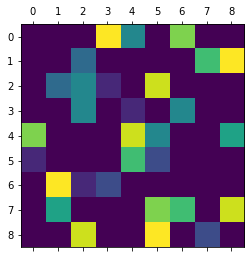

In [17]:
# Display matrix
plt.matshow(game0, cmap=viridis)
plt.show();

In [20]:
def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

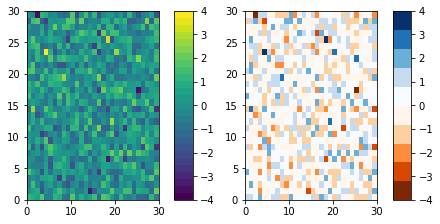

In [24]:
top = cm.get_cmap('Oranges_r', 5)
bottom = cm.get_cmap('Blues', 5)

newcolors = np.vstack((top(np.linspace(0, 1, 5)),
                       bottom(np.linspace(0, 1, 5))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')
plot_examples([viridis, newcmp])

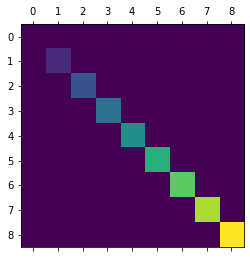

In [3]:
def samplemat(dims):
    """Make a matrix with all zeros and increasing elements on the diagonal"""
    aa = np.zeros(dims)
    for i in range(min(dims)):
        aa[i, i] = i
    return aa


# Display matrix
plt.matshow(samplemat((9,9)))
plt.show();

***